# Data Visualisation

## Import Libraries

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# Importing libs
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import plotly as py
import plotly.graph_objs as go
import os
py.offline.init_notebook_mode(connected = True)
#print(os.listdir("../input"))
import datetime as dt
import missingno as msno
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
plt.rcParams['figure.dpi'] = 140

## Import Data

In [4]:
netflix_data = pd.read_csv('input/netflix_titles.csv')
imdb_basics = pd.read_csv('input/imdb_title_basics.tsv',sep='\t')
imdb_ratings = pd.read_csv('input/imdb_title_ratings.tsv',sep='\t')

imdb_basics = imdb_basics.replace('\\N', 0)
imdb_ratings = imdb_ratings.replace('\\N', 0)

In [5]:
imdb_data = pd.merge(imdb_basics, imdb_ratings, how='left', left_on='tconst', right_on='tconst')

imdb_data['startYear'] = imdb_data['startYear'].astype(np.float).astype("Int64")

In [6]:
df = pd.merge(netflix_data, imdb_data, how='left', left_on=['title','release_year'], right_on=['primaryTitle','startYear'])
df = df.drop_duplicates(subset=['show_id'])
df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,...,movie,Dick Johnson Is Dead,Dick Johnson Is Dead,0,2020,0,89,"Biography,Documentary,Drama",7.4,6412.0
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,...,short,Blood & Water,Blood & Water,0,2021,0,0,"Drama,Short",NaN,NaN
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,...,tvSeries,Ganglands,Braqueurs,0,2021,0,44,"Action,Crime,Drama",7.0,2458.0


## Feature Engineering

In [7]:
# Missing data
for i in df.columns:
    null_rate = df[i].isna().sum() / len(df) * 100 
    if null_rate > 0 :
        print("{} null rate: {}%".format(i,round(null_rate,2)))

director null rate: 29.91%
cast null rate: 9.37%
country null rate: 9.44%
date_added null rate: 0.11%
rating null rate: 0.05%
duration null rate: 0.03%
tconst null rate: 30.78%
titleType null rate: 30.78%
primaryTitle null rate: 30.78%
originalTitle null rate: 30.78%
isAdult null rate: 30.78%
startYear null rate: 30.78%
endYear null rate: 30.78%
runtimeMinutes null rate: 30.78%
genres null rate: 30.78%
averageRating null rate: 37.07%
numVotes null rate: 37.07%


In [8]:
# Replacments
df['country'] = df['country'].fillna(df['country'].mode()[0])
df['cast'].replace(np.nan, 'No Data',inplace  = True)
df['director'].replace(np.nan, 'No Data',inplace  = True)

# Drops
df.dropna(inplace=True)

# Drop Duplicates
df.drop_duplicates(inplace= True)

In [9]:
df["date_added"] = pd.to_datetime(df['date_added'])
df['month_added']=df['date_added'].dt.month
df['month_name_added']=df['date_added'].dt.month_name()
df['year_added'] = df['date_added'].dt.year

In [10]:
# Quick feature engineering

# Helper column for various plots
df['count'] = 1

# Many productions have several countries listed - this will skew our results , we'll grab the first one mentioned

# Lets retrieve just the first country
df['primary_country'] = df['country'].apply(lambda x: x.split(",")[0])
df['primary_country'].head()

# Rating ages from this notebook: https://www.kaggle.com/andreshg/eda-beginner-to-expert-plotly (thank you!)

ratings_ages = {
    'TV-PG': 'Older Children',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Children',
    'TV-Y7': 'Older Children',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Children',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Children',
    'PG': 'Older Children',
    'G': 'Children',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

# Genre

df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 

# Reducing name length

df['primary_country'].replace('United States', 'USA', inplace=True)
df['primary_country'].replace('United Kingdom', 'UK',inplace=True)
df['primary_country'].replace('South Korea', 'S. Korea',inplace=True)

df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,genres,averageRating,numVotes,month_added,month_name_added,year_added,count,primary_country,target_ages,genre
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Data,United States,2021-09-25,2020,PG-13,90 min,...,"Biography,Documentary,Drama",7.4,6412.0,9,September,2021,1,USA,Teens,[Documentaries]
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,2021-09-24,2021,TV-MA,1 Season,...,"Action,Crime,Drama",7.0,2458.0,9,September,2021,1,USA,Adults,"[Crime TV Shows, International TV Shows, TV Ac..."
3,s4,TV Show,Jailbirds New Orleans,No Data,No Data,United States,2021-09-24,2021,TV-MA,1 Season,...,"Documentary,Reality-TV",6.6,205.0,9,September,2021,1,USA,Adults,"[Docuseries, Reality TV]"
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",United States,2021-09-24,2021,TV-MA,1 Season,...,"Drama,Fantasy,Horror",7.7,102164.0,9,September,2021,1,USA,Adults,"[TV Dramas, TV Horror, TV Mysteries]"
7,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",United States,2021-09-24,2021,PG,91 min,...,"Adventure,Animation,Comedy",6.8,3463.0,9,September,2021,1,USA,Older Children,[Children & Family Movies]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12609,s8801,TV Show,Zindagi Gulzar Hai,No Data,"Sanam Saeed, Fawad Khan, Ayesha Omer, Mehreen ...",Pakistan,2016-12-15,2012,TV-PG,1 Season,...,Romance,8.9,3510.0,12,December,2016,1,Pakistan,Older Children,"[International TV Shows, Romantic TV Shows, TV..."
12611,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,2019-11-20,2007,R,158 min,...,"Crime,Drama,Mystery",7.7,523725.0,11,November,2019,1,USA,Adults,"[Cult Movies, Dramas, Thrillers]"
12614,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,2019-11-01,2009,R,88 min,...,"Action,Comedy,Horror",7.6,560367.0,11,November,2019,1,USA,Adults,"[Comedies, Horror Movies]"
12618,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,2020-01-11,2006,PG,88 min,...,"Action,Adventure,Comedy",4.3,20959.0,1,January,2020,1,USA,Older Children,"[Children & Family Movies, Comedies]"


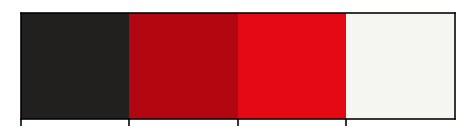

In [11]:
# Palette
colours = ['#f5f5f1', '#e50914', '#b20710','#221f1f']
sns.palplot(['#221f1f', '#b20710', '#e50914','#f5f5f1'])

plt.show()

## Top Producers of Content

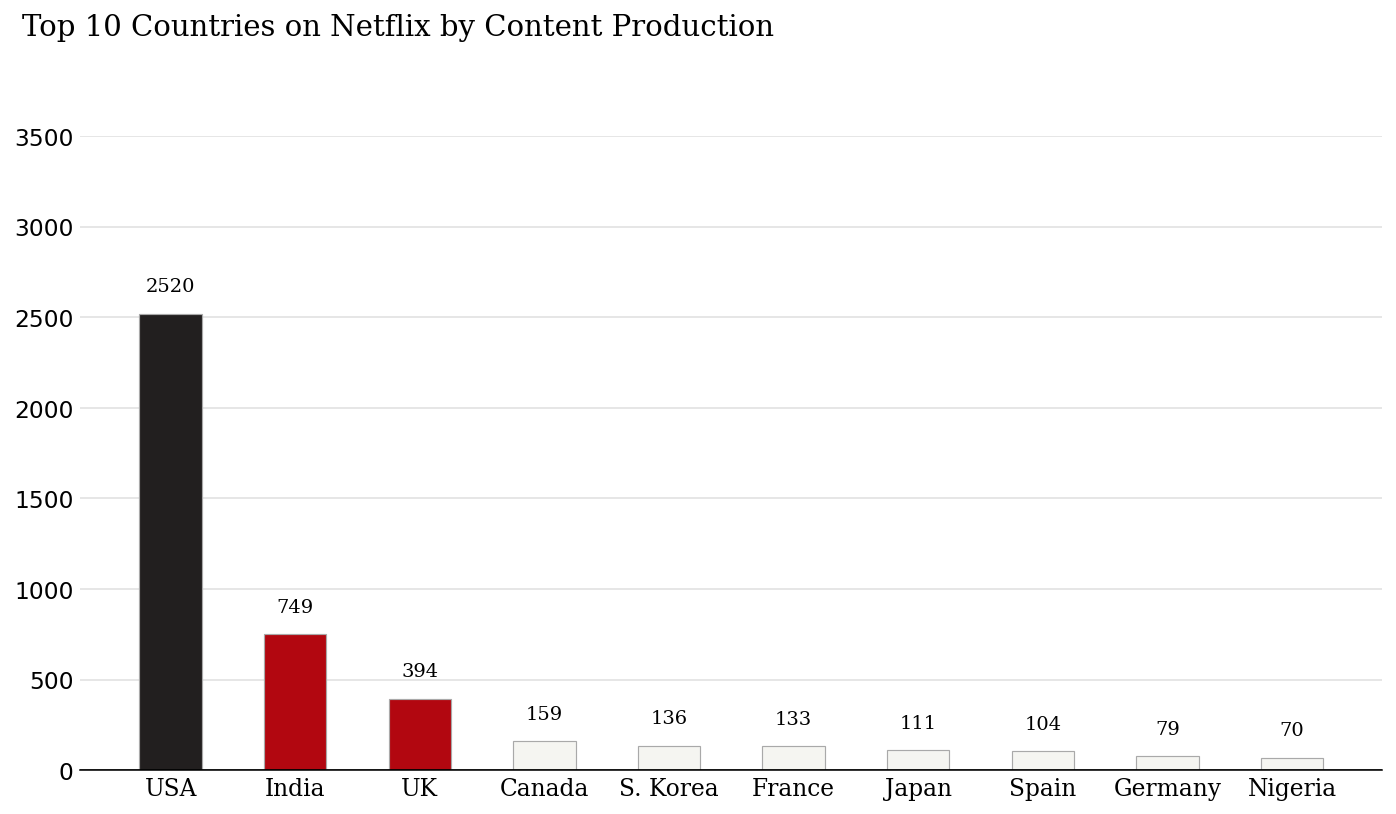

In [12]:
data = df.groupby('primary_country')['count'].sum().sort_values(ascending=False)[:10]

# Plot

color_map = ['#f5f5f1' for _ in range(10)]
color_map[0] =  '#221f1f' # color highlight
color_map[1] = color_map[2] = '#b20710'

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(data.index, data, width=0.5, 
       edgecolor='darkgray',
       linewidth=0.6,color=color_map)

#annotations
for i in data.index:
    ax.annotate(f"{data[i]}", 
                   xy=(i, data[i] + 150), #i like to change this to roughly 5% of the highest cat
                   va = 'center', ha='center',fontweight='light', fontfamily='serif')

# Remove border from plot

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# Tick labels

ax.set_xticklabels(data.index, fontfamily='serif', rotation=0)

# Title and sub-title

fig.text(0.09, 1, 'Top 10 Countries on Netflix by Content Production', fontsize=15, fontfamily='serif')

ax.grid(axis='y', linestyle='-', alpha=0.4)   

grid_y_ticks = np.arange(0, 4000, 500) # y ticks, min, max, then step
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

## Content Producers Over Time

In [13]:
year_country = df.groupby('year_added')['primary_country'].value_counts().reset_index(name='counts')

fig = px.choropleth(year_country, locations="primary_country", color="counts", 
                    locationmode='country names',
                    animation_frame='year_added',
                    range_color=[0,500],
                    color_continuous_scale=colours
                   )

fig.update_layout(title='Comparison by country',
                  autosize=False,
                  margin=dict(l=0, r=0, t=0, b=0, pad=4, autoexpand=True))

## Content Types

In [14]:
# For viz: Ratio of Movies & TV shows
x=df.groupby(['type'])['type'].count()
y=len(df)
r=((x/y)).round(2)

mf_ratio = pd.DataFrame(r)

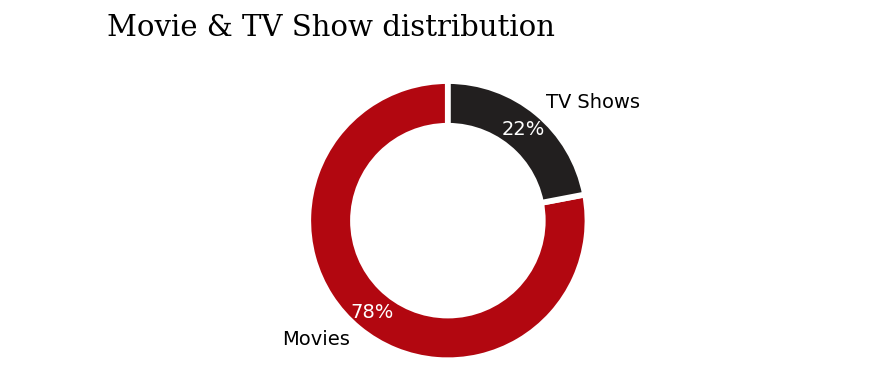

In [15]:
x = mf_ratio['type'].tolist()
y = ['Movies','TV Shows']

fig, ax, = plt.subplots(1,1,figsize=(6.5, 2.5))
patches, texts, pcts = ax.pie(x,labels=y,colors=['#b20710','#221f1f'],autopct='%.0f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, startangle=90, pctdistance=0.85)
plt.setp(pcts, color='white')
# Title & Subtitle
fig.text(0.125,1.03,'Movie & TV Show distribution', fontfamily='serif',fontsize=15)

# Removing legend due to labelled plot
ax.legend().set_visible(False)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  
plt.tight_layout()
plt.show()

## Content Types By Country

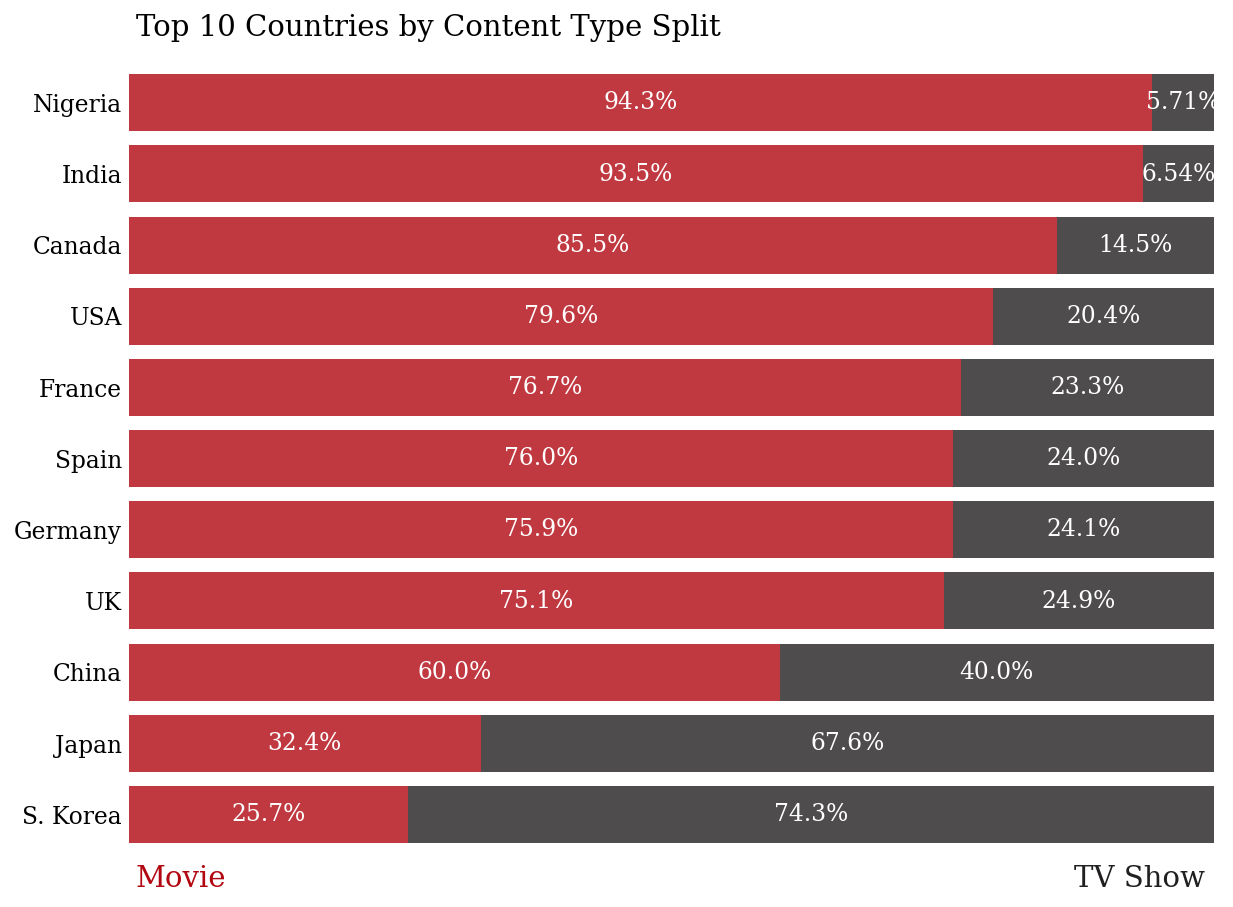

In [16]:
country_order = df['primary_country'].value_counts()[:11].index
data_q2q3 = df[['type', 'primary_country']].groupby('primary_country')['type'].value_counts().unstack().loc[country_order]
data_q2q3['sum'] = data_q2q3.sum(axis=1)
data_q2q3_ratio = (data_q2q3.T / data_q2q3['sum']).T[['Movie', 'TV Show']].sort_values(by='Movie',ascending=False)[::-1]

fig, ax = plt.subplots(1,1,figsize=(10, 8),)

ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Movie'], 
        color='#b20710', alpha=0.8, label='Movie')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['TV Show'], left=data_q2q3_ratio['Movie'], 
        color='#221f1f', alpha=0.8, label='TV Show')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)

# male percentage
for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['Movie'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['TV Show'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]+data_q2q3_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    

fig.text(0.13, 0.88, 'Top 10 Countries by Content Type Split', fontsize=15, fontfamily='serif')  

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
fig.text(0.13,0.12,"Movie", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.80,0.12,"TV Show", fontfamily='serif', fontsize=15, color='#221f1f')

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

## Genre Correlation

In [17]:
# Genres
from sklearn.preprocessing import MultiLabelBinarizer 

import matplotlib.colors

# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#b20710','#f5f5f1','#221f1f'])

def genre_heatmap(df, title):
    df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
    Types = []
    for i in df['genre']: Types += i
    Types = set(Types)
    print("There are {} types in the Netflix {} Dataset".format(len(Types),title))    
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)
    corr = res.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10, 7))
    fig.text(.54,.88,'Genre correlation', fontfamily='serif',fontsize=15)
    pl = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, vmin=-.3, center=0, square=True, linewidths=2.5)
    
    plt.show()

There are 20 types in the Netflix Movie Dataset


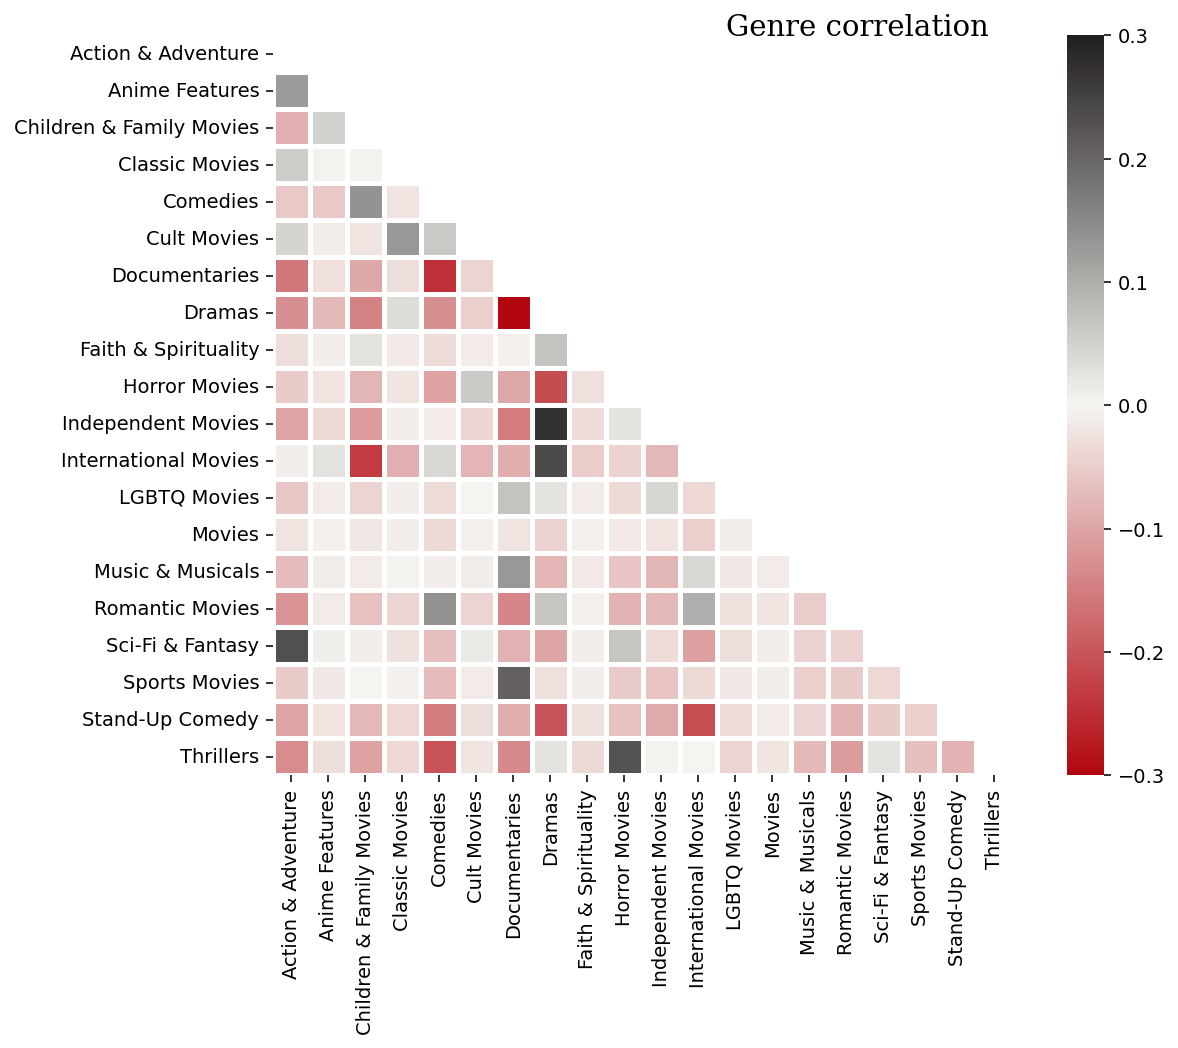

In [18]:
df_tv = df[df["type"] == "TV Show"]
df_movies = df[df["type"] == "Movie"]


genre_heatmap(df_movies, 'Movie')
plt.show()

## Age Group Targeting

In [19]:
data = df.groupby('primary_country')[['primary_country','count']].sum().sort_values(by='count',ascending=False).reset_index()[:10]
data = data['primary_country']


df_heatmap = df.loc[df['primary_country'].isin(data)]

In [20]:
df_heatmap = pd.crosstab(df_heatmap['primary_country'],df_heatmap['target_ages'],normalize = "index").T
df_heatmap = df_heatmap.transpose()

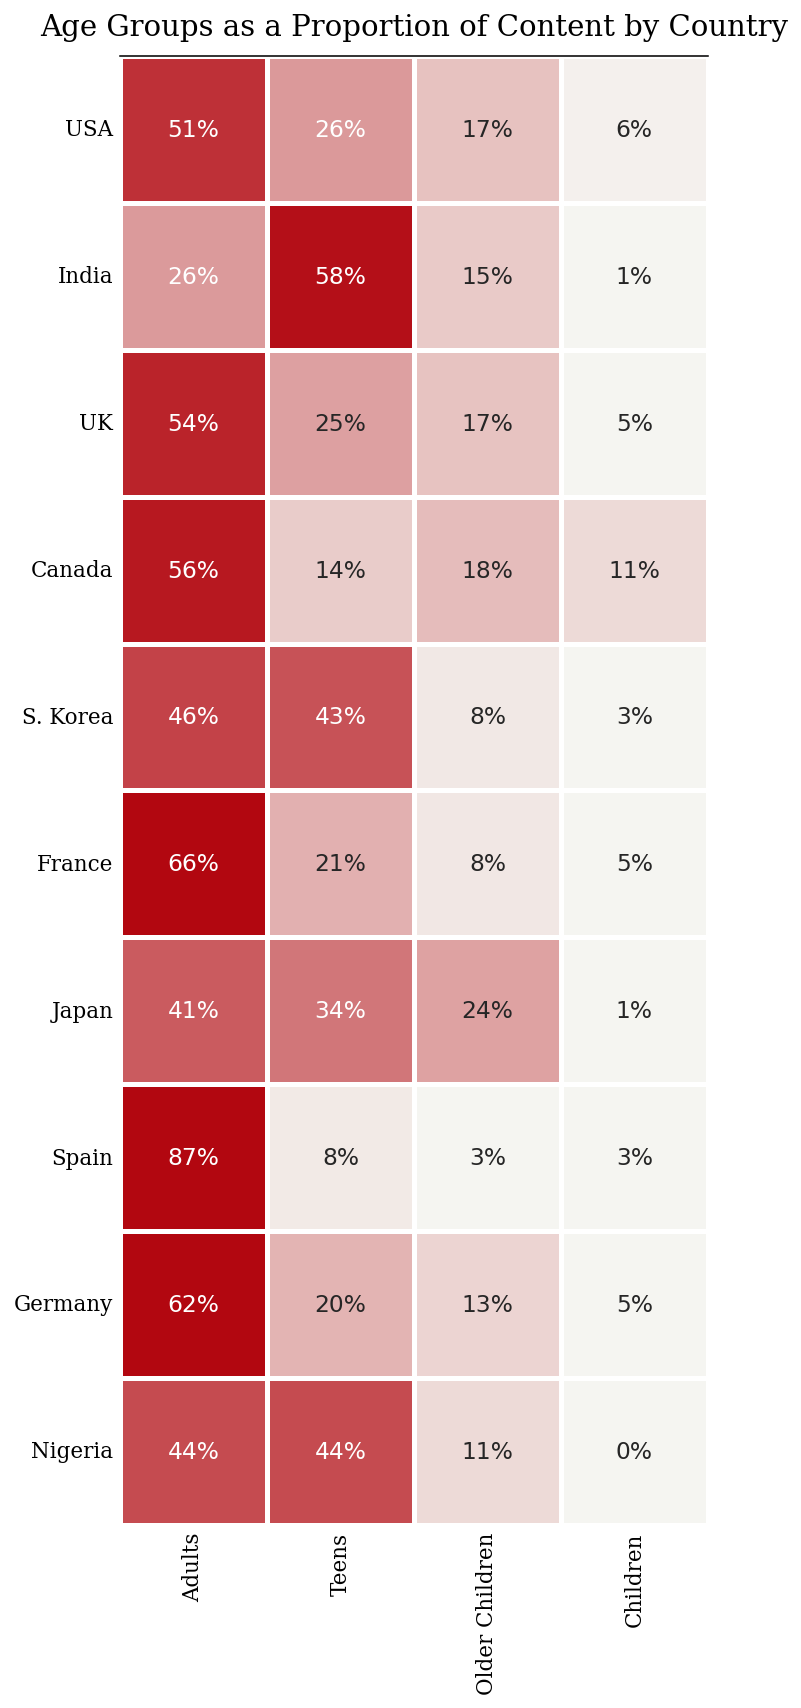

In [25]:
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#f5f5f1','#b20710'])

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

country_order2 = ['USA', 'India', 'UK', 'Canada', 'S. Korea', 'France', 'Japan', 'Spain',
       'Germany', 'Nigeria']

age_order = ['Adults','Teens','Older Children','Children']

sns.heatmap(df_heatmap.loc[country_order2,age_order],cmap=cmap2,square=True, linewidth=2.5,cbar=False,
            annot=True,fmt='1.0%',vmax=.6,vmin=0.05,ax=ax,annot_kws={"fontsize":12})

ax.spines['top'].set_visible(True)


fig.text(.5, 1, 'Age Groups as a Proportion of Content by Country', fontfamily='serif', fontsize=15,ha='center')   
ax.set_yticklabels(ax.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
plt.show()

## Movie Durations

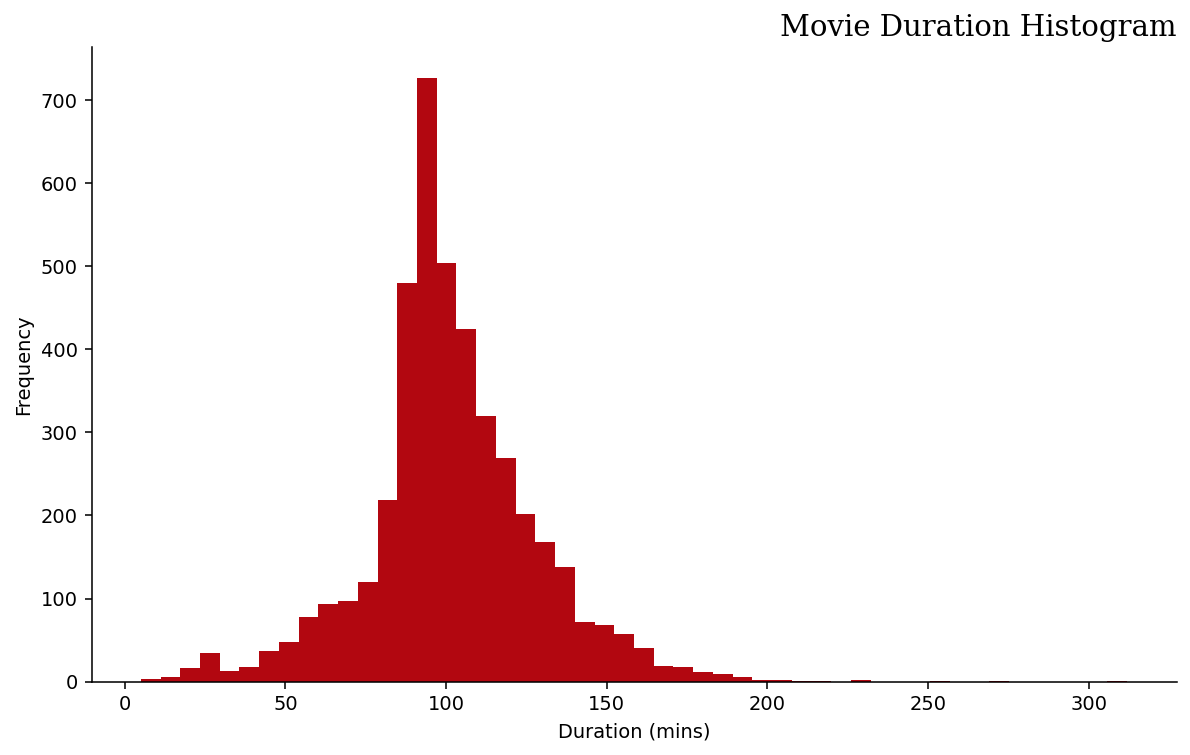

In [22]:
movies = df[df['type'].str.contains("Movie")]
movies = movies[['title','duration']]

movies['duration']=movies['duration'].str.replace(' min','')

movies['duration']=movies['duration'].astype(str).astype(int)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(movies['duration'], bins=50, color = "#b20710")

plt.title('Movie Duration Histogram', loc='Right', fontsize=15, fontfamily='serif')  

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    
ax.set_xlabel('Duration (mins)')
ax.set_ylabel('Frequency')

plt.show()

## Average IMDb Ratings

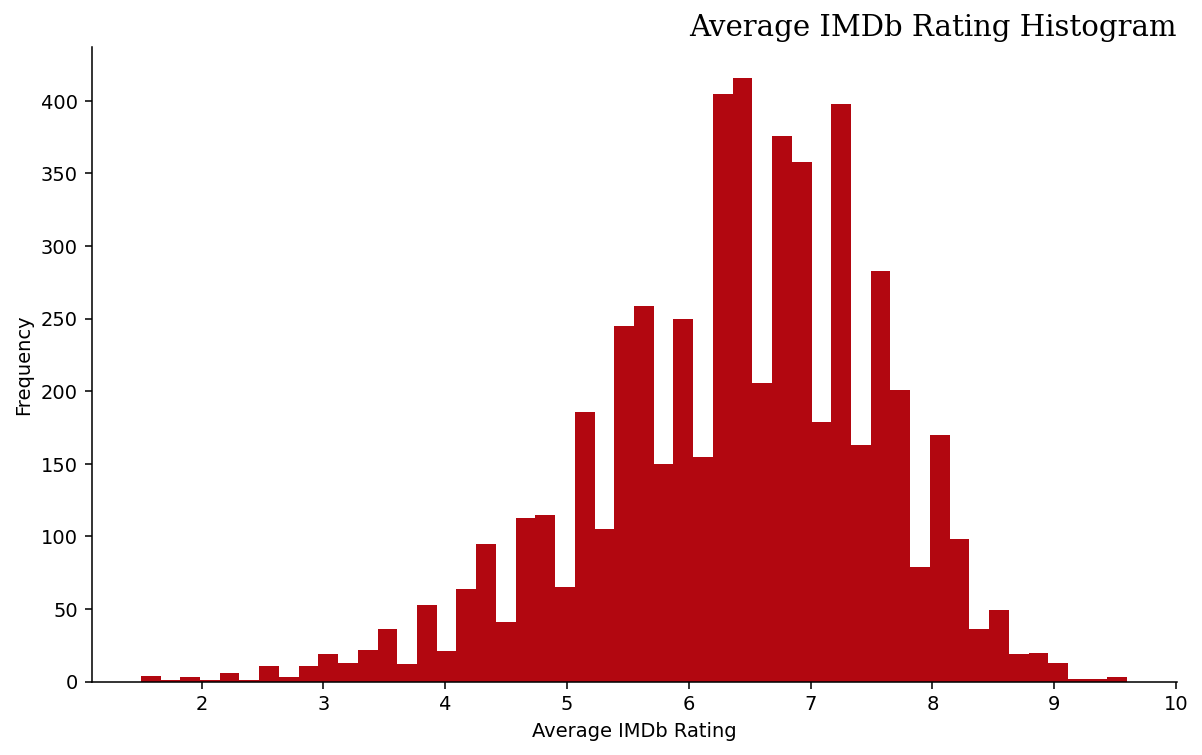

In [26]:
ratings = df[['title','averageRating']]

ratings['averageRating']=ratings['averageRating']

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(ratings['averageRating'], bins=50, color = "#b20710")

plt.title('Average IMDb Rating Histogram', loc='Right', fontsize=15, fontfamily='serif')  

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    
ax.set_xlabel('Average IMDb Rating')
ax.set_ylabel('Frequency')

plt.show()

# Title Keywords

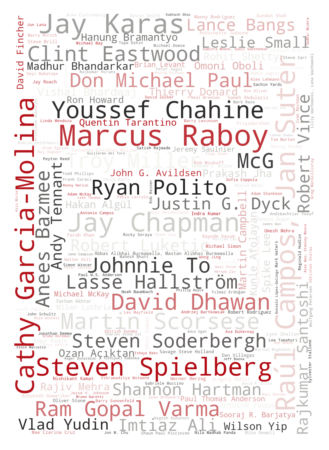

In [27]:
director = df[df['type'].str.contains("Movie")]
director = director['director'].value_counts()
director = director.reset_index()
director = pd.DataFrame(director).rename(columns={'index':'directors','director':'count'})
director = director[1:]

director = director.set_index('directors').to_dict()['count']

wc = WordCloud(width=1000, height=1400, max_words=200,background_color='white',colormap=cmap,random_state=1).generate_from_frequencies(director)

# Display the generated image:
# the matplotlib way:
plt.imshow(wc, interpolation='bilinear')
plt.rcParams["figure.figsize"] = (8,8)
plt.axis("off")
plt.show()

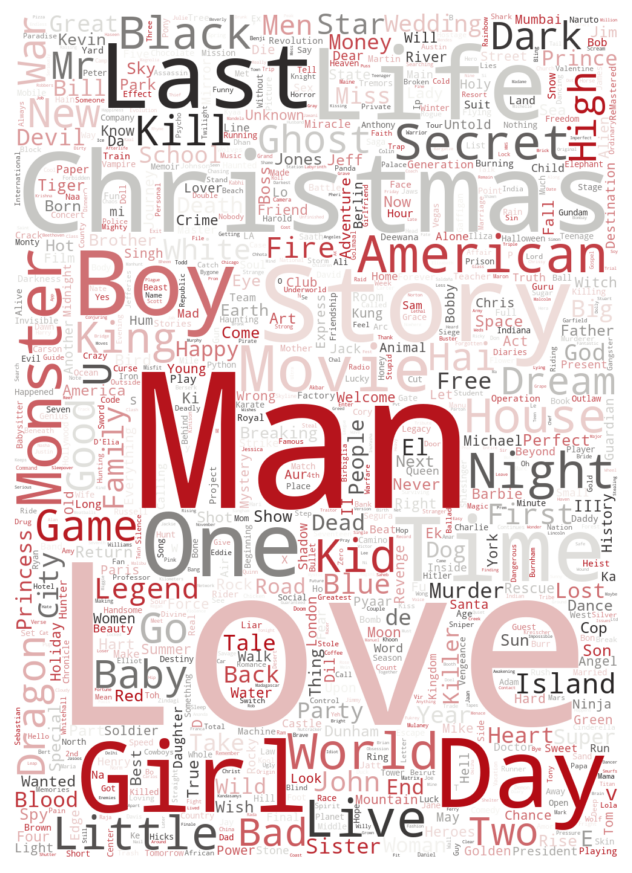

In [28]:
wc = df[df['type'].str.contains("Movie")]
wordcloud = WordCloud(width=1000, height=1400, max_words=1000,background_color='white',colormap=cmap,random_state=1, collocations=False, stopwords = STOPWORDS).generate(' '.join(wc['title']))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.rcParams["figure.figsize"] = (8,8)
plt.axis("off")
plt.show()